# Battle of the neighborhoods - Build a baseball stadium in Montreal

##  Introduction / Business Problem

In this project, we will be looking for the best location to build a new baseball stadium in Montreal, Canada.

Montreal is the most populous city in the province of Quebec in Canada. It's an island that cuts the Saint Lawrence River in half. For this project, we will consider all the neighborhoods of the island of Montreal.

16 years ago, Montreal lost its baseball team, the Montreal Expos. The team was moved to Washington D.C. At the end of the 1990s, Expos slowly disapperead from Montreal's sports landscape. Baseball fans lost interest in their team. That led to the relocation of the Expos.

The major reason for this failure was the poor location of the Olympic Stadium. The stadium was far from population centres, restaurants, and bars. Basically, there was nothing to do around the stadium before and after the game. People could not eat at a good restaurant before the game and have a drink after.

For 5 years, private investors have been looking to bring baseball back in town and to acquire a Major League Baseball (MLB) team for Montreal. The condition from the MLB for a return of baseball in Montreal is a new stadium. For such a project, public investments from the government are needed.

The goal of this project is to present to the Montreal City Council the optimal location for a new baseball stadium so public funds can be allocated to the project. The private investors need the help of data science to convince the Council of the optimal location.

For a location to be optimal, there must have restaurants and bars around the stadium. We will use a clustering model to cluster neighborhoods based on their similarities. We will make sure that the selected location does not share the same cluster as the old Olympic Stadium.

## Data

To address our problem, we will need the following information:
* **Density of population** : We want the stadium to be in a neighborhood with a high-density population. In Montreal, neighborhoods with big population are well served by public transportation and we want the stadium to be easily accessible. Having a lot of people living around the stadium would also evoke a sense of belonging to the team.
* **Number of restaurants in the neighborhood**
* **Number of bars in the neighborhood**
* **Number of stores and shops in the neighborhood**
    
To define the neighborhoods of Montreal, we will use postal codes. The list of postal codes of Montreal can be found here:
[Wiki Montreal Postal Codes](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H) Some postal codes are not used. They will be ignored. *Example of a neighborhood: H1A - Pointes-aux-Trembles*

Coordinates of neighborhoods will be obtained using geocoder. Exactly like we did in the previous lab.
    
Restaurants, bars, stores and shops in each neighborhood will be obtained with the help of Foursquare API. We will explore each neighborhood to get the most popular venues. *Example: get the top 10 venues around the location of a postal code and sort them by popularity*

For density of population, we can use Statistics Canada 2016 Census. Each postal code has its corresponding population :
[Population and dwelling counts](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A) We will extract the population for each postal code of our dataset. *Example: H1A - Pointes-aux-Trembles has a population of 32,516*

To create a map of Montreal using Folium, Montreal shape file is available here : [Montreal shapefile](https://jmacman12.carto.com/tables/montreal_shapefile/public)

## Analysis

#### Download all the dependencies

In [1]:
import pandas as pd
import numpy as np
import re
import json
import requests
import types
import ibm_boto3
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from botocore.client import Config
from sklearn.cluster import KMeans

!pip install geocoder
import geocoder

!pip install folium==0.5
import folium

!pip install geopy
from geopy.geocoders import Nominatim

     |████████████████████████████████| 98 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 79 kB 9.6 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=124188829b7b5b364a794e28a73849b61b6598717a5837e0fde3e1c11b7d76d3
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


#### Scrape Wikipedia page, create dataframe and clean it

In [2]:
# Scrape Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
page = requests.get(url)
table = BeautifulSoup(page.content, 'html.parser').find_all("table")[0]

raw_data = [[cell.text for cell in row.find_all(["th","td"])]
            for row in table.find_all("tr")]

# Clean data
postal_codes = []
neighborhoods = []

for i in range(len(raw_data)):
    for j in range(len(raw_data[i])):
        entry = raw_data[i][j].replace("\n", "") # remove new lines
        
        postal_codes.append(entry[:3])
        
        neighborhood = entry[3:].strip()                              # remove leading and trailing spaces
        neighborhood = re.sub(r"(\w)([A-Z])", r"\1 \2", neighborhood) # Add a space before capital letters
        neighborhood = re.sub(r'\([^)]*\)', '', neighborhood)         # Remove parentheses and their content
        neighborhood = re.sub(r'\[[^)]*\]', '', neighborhood)         # Remove brackets and their content
        neighborhoods.append(neighborhood)

# Create dataframe 
mtl_neighborhoods = pd.DataFrame({'PostalCode': postal_codes,
                                  'Neighborhood': neighborhoods})

# Ignore cells with a neighborhood that is 'Not assigned'
mtl_neighborhoods.drop(mtl_neighborhoods[ mtl_neighborhoods['Neighborhood'] == 'Not assigned' ].index , inplace=True)

# Ignore two invalid postal codes
mtl_neighborhoods.drop(mtl_neighborhoods[ mtl_neighborhoods['PostalCode'] == 'H0H' ].index , inplace=True)
mtl_neighborhoods.drop(mtl_neighborhoods[ mtl_neighborhoods['PostalCode'] == 'H0M' ].index , inplace=True)
mtl_neighborhoods.reset_index(inplace=True, drop=True)

mtl_neighborhoods.head()

,PostalCode,Neighborhood
0,H1A,Pointe-aux-Trembles
1,H2A,"Saint-Michel,East"
2,H3A,Downtown Montreal North
3,H4A,Notre-Dame-de-Grâce Northeast
4,H5A,Place Bonaventure


In [3]:
mtl_neighborhoods.shape

(121, 2)

#### Check that each postal code is unique

In [4]:
mtl_neighborhoods['PostalCode'].nunique() == mtl_neighborhoods.shape[0]

True

#### Get latitude/longitude for each postal code using geocoder

In [5]:
postal_codes = [x for x in mtl_neighborhoods['PostalCode']]
latitudes = []
longitudes = []

for i in range(len(postal_codes)):
    lat_lng_coords = None
    
    # loop until we get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Montreal, Quebec'.format(postal_codes[i]))
        lat_lng_coords = g.latlng

    latitudes.append(lat_lng_coords[0])
    longitudes.append(lat_lng_coords[1])

temp = pd.DataFrame({'PostalCode': postal_codes, 
                     'Latitude': latitudes,
                     'Longitude': longitudes})

In [6]:
mtl_neighborhoods = mtl_neighborhoods.merge(temp, on='PostalCode')
mtl_neighborhoods.head()

,PostalCode,Neighborhood,Latitude,Longitude
0,H1A,Pointe-aux-Trembles,45.67474,-73.50009
1,H2A,"Saint-Michel,East",45.56153,-73.59985
2,H3A,Downtown Montreal North,45.50533,-73.57488
3,H4A,Notre-Dame-de-Grâce Northeast,45.47241,-73.61586
4,H5A,Place Bonaventure,45.49878,-73.56580


#### Get population for each neighborhood

In [7]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_dd47c561d8ea452498baf277040030e3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='uszZtxz1AnVoWoMiIpXA5I443MUi-zEC0p7voH1vUD92',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_dd47c561d8ea452498baf277040030e3.get_object(Bucket='capstone-donotdelete-pr-etbtcx3uzcunbx',Key='data_asset/Census2016_CSV_ar2t4h5xuthctnfcbmu71oukr.CSV')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

temp = pd.read_csv(body)
temp.drop('Province or territory', 1, inplace=True)
column_names = ['PostalCode', 'Population']
temp.columns = column_names
temp.head()

,PostalCode,Population
0,A0A,46587
1,A0B,19792
2,A0C,12587
3,A0E,22294
4,A0G,35266


In [8]:
mtl_neighborhoods = mtl_neighborhoods.merge(temp, on='PostalCode')
mtl_neighborhoods.head()

,PostalCode,Neighborhood,Latitude,Longitude,Population
0,H1A,Pointe-aux-Trembles,45.67474,-73.50009,32516
1,H2A,"Saint-Michel,East",45.56153,-73.59985,19651
2,H3A,Downtown Montreal North,45.50533,-73.57488,3580
3,H4A,Notre-Dame-de-Grâce Northeast,45.47241,-73.61586,26453
4,H5A,Place Bonaventure,45.49878,-73.56580,0


In [9]:
mtl_neighborhoods.shape

(121, 5)

#### Use geopy library to get the latitude and longitude values of Montreal

In [10]:
address = 'Montreal, Canada'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
mtl_latitude = location.latitude
mtl_longitude = location.longitude
print('The geograpical coordinate of Montreal are {}, {}.'.format(mtl_latitude, mtl_longitude))

The geograpical coordinate of Montreal are 45.4972159, -73.6103642.


#### Define some information about old Olympic Stadium

In [11]:
# Postal code, latitude and longitude found on Google
olympic_stadium_postalcode = 'H1V'
label = folium.Popup('Olympic Stadium', parse_html=True)
olympic_stadium_marker = folium.CircleMarker([45.558941, -73.551468],radius=5,popup=label,color='black',
                                             fill=True,fill_color='#80ff00',fill_opacity=0.7,parse_html=False)

#### Simplify the dataframe. Let's keep only top 60 neighborhoods sorted by population in decreasing order.

In [14]:
mtl_reduced= mtl_neighborhoods.sort_values('Population',ascending = False).head(60)
mtl_reduced.head()

,PostalCode,Neighborhood,Latitude,Longitude,Population
26,H1G,Montréal-Nord North,45.61298,-73.61998,48556
20,H1E,Rivière-des-Prairies Southwest,45.63676,-73.58604,42420
64,H7N,Laval-des-Rapides,45.51240,-73.55469,42318
102,H7W,Chomedey South,45.51240,-73.55469,41619
54,H7L,Sainte-Rose,45.51240,-73.55469,37252


In [15]:
mtl_reduced.shape

(60, 5)

#### Let's keep neighborhoods in downtown. They don't have a big population but they have a lot of workers.

In [16]:
mtl_reduced=mtl_reduced.append(mtl_neighborhoods[mtl_neighborhoods['Neighborhood'].str.contains("Downtown")], ignore_index=True)
mtl_reduced.tail()

,PostalCode,Neighborhood,Latitude,Longitude,Population
60,H3A,Downtown Montreal North,45.50533,-73.57488,3580
61,H3B,Downtown Montreal East,45.49988,-73.56868,581
62,H3G,Downtown Montreal Southeast,45.49844,-73.57879,7457
63,H3H,Downtown Montreal Southwest,45.48846,-73.58296,19025
64,H2Z,Downtown Montreal Northeast,45.50553,-73.56133,2313


In [17]:
mtl_reduced.shape

(65, 5)

#### Create a map of Montreal with remaining neighborhoods and old Olympic Stadium superimposed on top

In [18]:
map_mtl = folium.Map(location=[mtl_latitude, mtl_longitude], zoom_start=11)

# Add markers to map
for lat, lng, neighborhood in zip(mtl_reduced['Latitude'], mtl_reduced['Longitude'], mtl_reduced['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl)  

olympic_stadium_marker.add_to(map_mtl)
    
map_mtl

#### Function to get nearby venues

In [22]:
# @hidden_cell
CLIENT_ID = '4LFUYDKVYTE22WK2OEQGF4KTMFOKW1WD3DYT1UPNLHCV5UQQ'
CLIENT_SECRET = 'KIOFP0HTGRHKKJGI55SY3TE0P3TKSQVPDOS1SVICDO5REKK1'
VERSION = '20180605'
LIMIT = 100

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Create a new dataframe called mtl_venues with results from Foursquare

In [24]:
mtl_venues = getNearbyVenues(names=mtl_reduced['Neighborhood'],
                             latitudes=mtl_reduced['Latitude'],
                             longitudes=mtl_reduced['Longitude'])

#### Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(mtl_venues['Venue Category'].unique())))

There are 203 uniques categories.


#### One hot encoding

In [26]:
mtl_onehot = pd.get_dummies(mtl_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
mtl_onehot['Neighborhood'] = mtl_venues['Neighborhood']

mtl_onehot.head()

,Accessories Store,Adult Boutique,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,BBQ Joint,...,Toy / Game Store,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood and by taking the sum of occurrence of each category

In [27]:
mtl_grouped = mtl_onehot.groupby('Neighborhood').sum().reset_index()

restaurant_columns = [col for col in mtl_grouped.columns if 'Restaurant' in col]
bar_columns        = [col for col in mtl_grouped.columns if 'Bar' in col]
store_shop_columns = [col for col in mtl_grouped.columns if any(x in col for x in ['Store', 'Shop'])]

mtl_grouped['TotalRestaurants'] = mtl_grouped[restaurant_columns].sum(axis=1)
mtl_grouped['TotalBars']        = mtl_grouped[bar_columns].sum(axis=1)
mtl_grouped['TotalStoresShops'] = mtl_grouped[store_shop_columns].sum(axis=1)

print(len(restaurant_columns))
print(len(bar_columns))
print(len(store_shop_columns))

mtl_grouped = mtl_grouped[['Neighborhood','TotalRestaurants','TotalBars','TotalStoresShops']]
mtl_grouped.head()

44
12
52


,Neighborhood,TotalRestaurants,TotalBars,TotalStoresShops
0,Ahuntsic Southwest,0,0,2
1,Anjou East,1,0,1
2,Auteuil South,6,2,4
3,Centre-Sud North,7,0,4
4,Centre-Sud South,12,6,10


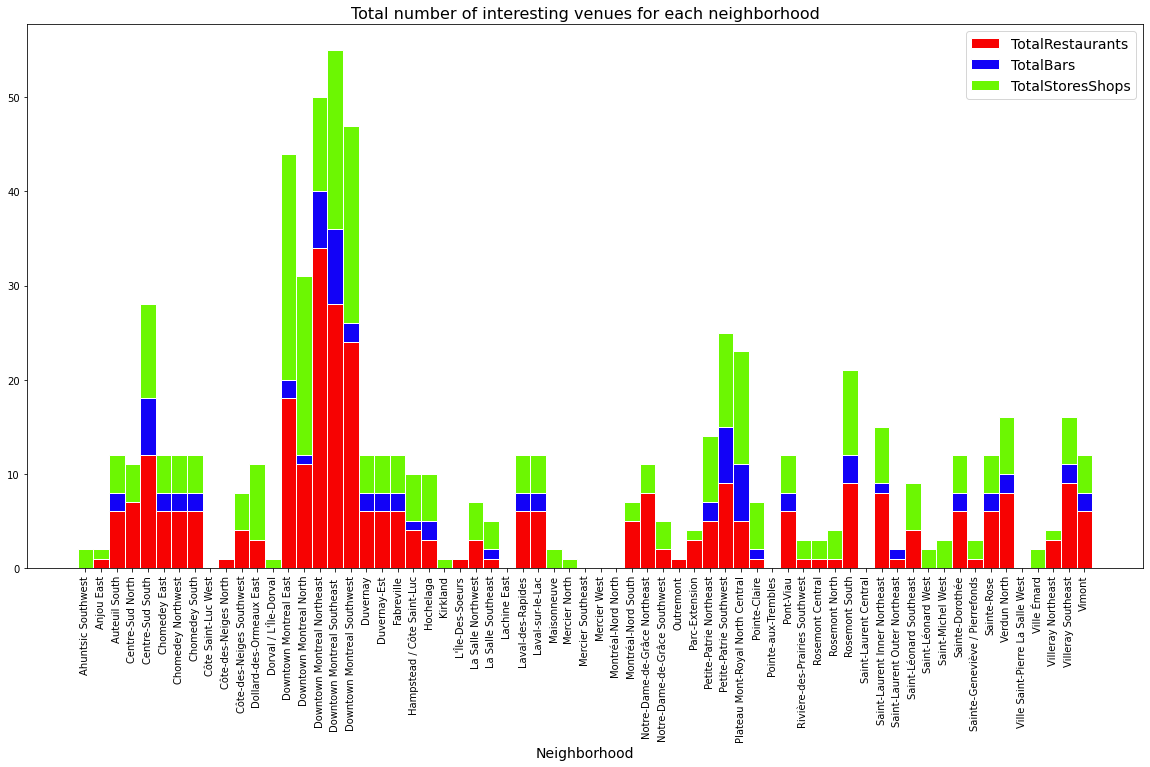

In [54]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20,10)) # set the size that you'd like (width, height)
# Values of each group
bars1 = np.array(mtl_grouped['TotalRestaurants'])
bars2 = np.array(mtl_grouped['TotalBars'])
bars3 = np.array(mtl_grouped['TotalStoresShops'])
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = np.array(mtl_grouped['Neighborhood'])
 
barWidth = 1
 
plt.bar(r, bars1, color='#f70202', edgecolor='white', width=barWidth, label='TotalRestaurants')
plt.bar(r, bars2, bottom=bars1, color='#1202f7', edgecolor='white', width=barWidth, label='TotalBars')
plt.bar(r, bars3, bottom=bars, color='#6cf702', edgecolor='white', width=barWidth, label='TotalStoresShops')
 
# Custom X axis
ax.legend(fontsize = 14)
ax.set_title("Total number of interesting venues for each neighborhood", fontsize=16)
plt.xlabel("Neighborhood", fontsize = 14)
plt.xticks(rotation=90)
 
# Show graphic
plt.show()

#### Run k-means to cluster the neighborhoods into 6 clusters.

In [55]:
kclusters = 6

mtl_grouped_clustering = mtl_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mtl_grouped_clustering)

mtl_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

mtl_merged = mtl_reduced
mtl_merged = mtl_merged.join(mtl_grouped.set_index('Neighborhood'), on='Neighborhood')
mtl_merged

,PostalCode,Neighborhood,Latitude,Longitude,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
0,H1G,Montréal-Nord North,45.61298,-73.61998,48556,1,0,0,0
1,H1E,Rivière-des-Prairies Southwest,45.63676,-73.58604,42420,1,1,0,2
2,H7N,Laval-des-Rapides,45.51240,-73.55469,42318,4,6,2,4
3,H7W,Chomedey South,45.51240,-73.55469,41619,4,6,2,4
4,H7L,Sainte-Rose,45.51240,-73.55469,37252,4,6,2,4
...,...,...,...,...,...,...,...,...,...
60,H3A,Downtown Montreal North,45.50533,-73.57488,3580,3,11,1,19
61,H3B,Downtown Montreal East,45.49988,-73.56868,581,3,18,2,24
62,H3G,Downtown Montreal Southeast,45.49844,-73.57879,7457,2,28,8,19
63,H3H,Downtown Montreal Southwest,45.48846,-73.58296,19025,2,24,2,21


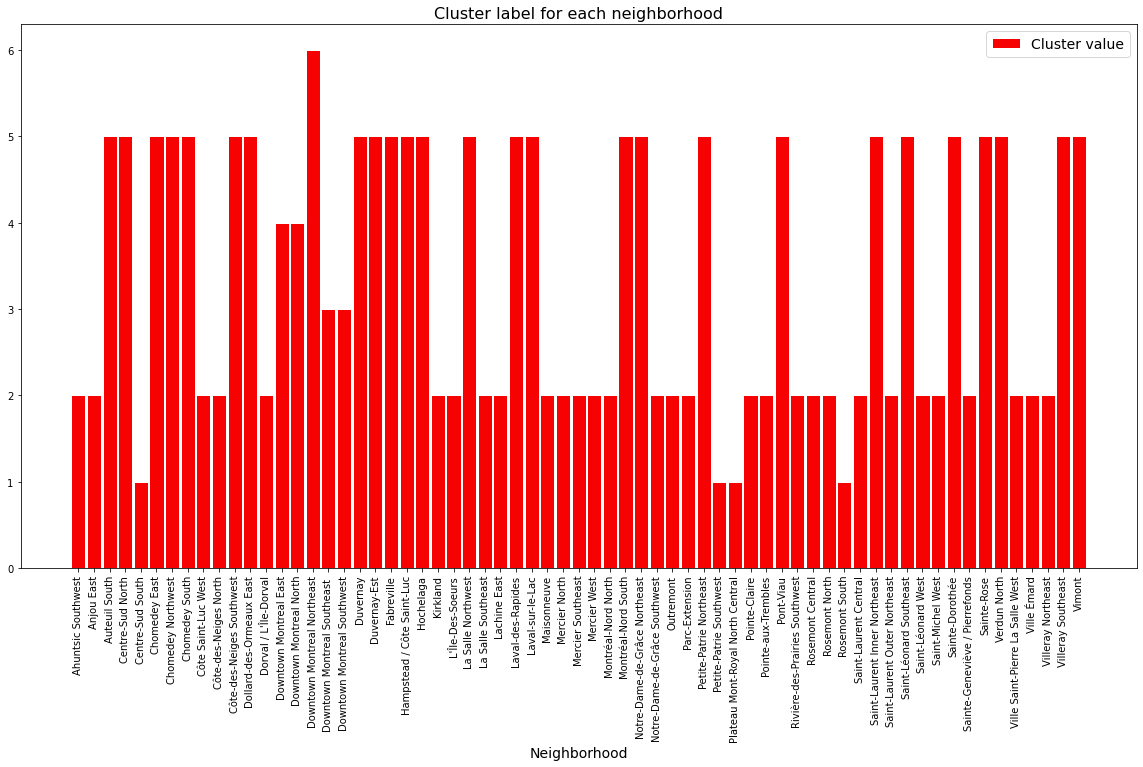

In [65]:
f, ax = plt.subplots(figsize=(20,10)) # set the size that you'd like (width, height)
# Values of each group
bars = np.array(mtl_grouped['Cluster Labels'])
bars += 1

# The position of the bars on the x-axis
r = np.array(mtl_grouped['Neighborhood'])
 
barWidth = 0.9
 
plt.bar(r, bars, color='#f70202', edgecolor='white', width=barWidth, label='Cluster value')
 
# Custom X axis
ax.legend(fontsize = 14)
ax.set_title("Cluster label for each neighborhood", fontsize=16)
plt.xlabel("Neighborhood", fontsize = 14)
plt.xticks(rotation=90)
 
# Show graphic
plt.show()

#### Visualize the resulting clusters

In [56]:
# create map
map_clusters = folium.Map(location=[mtl_latitude, mtl_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mtl_merged['Latitude'], mtl_merged['Longitude'], mtl_merged['Neighborhood'], mtl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

olympic_stadium_marker.add_to(map_clusters)
map_clusters

#### Cluster 1

In [67]:
mtl_merged.loc[mtl_merged['Cluster Labels'] == 0, mtl_merged.columns[[1] + list(range(4, mtl_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
29,Petite-Patrie Southwest,27359,0,9,6,10
30,Rosemont South,27172,0,9,3,9
32,Plateau Mont-Royal North Central,26559,0,5,6,12
41,Centre-Sud South,24222,0,12,6,10


#### Cluster 2

In [33]:
mtl_merged.loc[mtl_merged['Cluster Labels'] == 1, mtl_merged.columns[[1] + list(range(4, mtl_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
0,Montréal-Nord North,48556,1,0,0,0
1,Rivière-des-Prairies Southwest,42420,1,1,0,2
7,Saint-Michel West,35472,1,0,0,3
9,Anjou East,34821,1,1,0,1
10,Mercier North,33468,1,0,0,1
11,Côte-des-Neiges North,33125,1,1,0,0
12,Pointe-aux-Trembles,32516,1,0,0,0
13,Rosemont North,31338,1,1,0,3
14,Outremont,31323,1,1,0,0
15,Saint-Léonard West,30903,1,0,0,2


#### Cluster 3

In [34]:
mtl_merged.loc[mtl_merged['Cluster Labels'] == 2, mtl_merged.columns[[1] + list(range(4, mtl_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
62,Downtown Montreal Southeast,7457,2,28,8,19
63,Downtown Montreal Southwest,19025,2,24,2,21


#### Cluster 4

In [68]:
mtl_merged.loc[mtl_merged['Cluster Labels'] == 3, mtl_merged.columns[[1] + list(range(4, mtl_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
60,Downtown Montreal North,3580,3,11,1,19
61,Downtown Montreal East,581,3,18,2,24


#### Cluster 5

In [36]:
mtl_merged.loc[mtl_merged['Cluster Labels'] == 4, mtl_merged.columns[[1] + list(range(4, mtl_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
2,Laval-des-Rapides,42318,4,6,2,4
3,Chomedey South,41619,4,6,2,4
4,Sainte-Rose,37252,4,6,2,4
5,Saint-Laurent Inner Northeast,36795,4,8,1,6
6,Montréal-Nord South,36127,4,5,0,2
8,Fabreville,35056,4,6,2,4
16,Côte-des-Neiges Southwest,30678,4,4,0,4
19,Laval-sur-le-Lac,30051,4,6,2,4
22,Verdun North,29488,4,8,2,6
23,La Salle Northwest,29465,4,3,0,4


#### Cluster 6

In [37]:
mtl_merged.loc[mtl_merged['Cluster Labels'] == 5, mtl_merged.columns[[1] + list(range(4, mtl_merged.shape[1]))]]

,Neighborhood,Population,Cluster Labels,TotalRestaurants,TotalBars,TotalStoresShops
64,Downtown Montreal Northeast,2313,5,34,6,10
